# Ejercicio 3 - Parcial

Se busca modelar la cantidad de likes diarios que recibe un posteo en Instagram los 30 días
posteriores a su publicación. Para eso, consideramos muestras (𝑥1, 𝑦1), . . . , (𝑥𝑛, 𝑦𝑛) de las variables
aleatorias 𝑋, los días desde el posteo, que toma valores entre 0 y 30, y 𝑌, la cantidad de likes por
día, que es un proceso de Poisson que debe reflejar de manera razonable el fenómeno (por ejemplo,
los primeros días se dan muchos likes y después van decayendo en el tiempo).

## a)
Generar muestras sintéticas 𝑥 = (𝑥1, . . . , 𝑥𝑛), 𝑦 = (𝑦1, . . . , 𝑦𝑛) para 𝑛 = 100. Graficar 𝑦 vs 𝑥.

## Desarrollo

Como primer paso parto por generar las muestras y guardarlas en variables X e Y:

In [1]:
import numpy as np

# Planto la semilla para poder replicar
np.random.seed(19)

# Genero la matriz de diseño X que contiene los días 
X = np.random.randint(0,31, 100)
intercepto = np.ones(X.shape)
X_intercepto = np.column_stack((intercepto, X))

# Planteo los verdaderos coeficientes de forma tal que cuando X crezca, Y decrezca
verdaderos_beta = np.array([5, -0.3])

# Ahora si le doy valores a Y
lambda_poisson = np.exp(np.dot(X_intercepto, verdaderos_beta))
Y = np.random.poisson(lambda_poisson)

Ahora armo el gráfico de X vs Y:

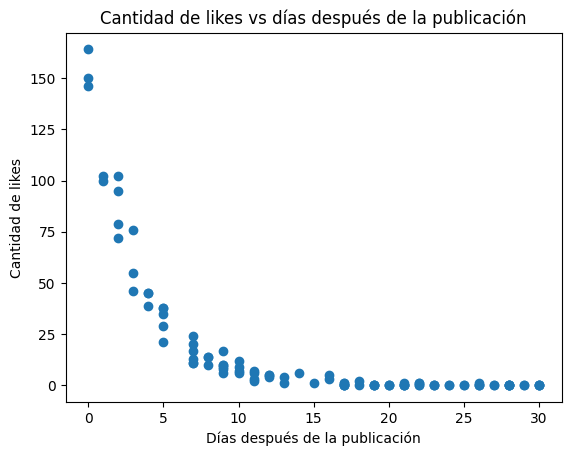

In [79]:
import matplotlib.pyplot as plt

# Armo el gráfico de X (días despues de la publicación) vs Y (cantidad de likes)
plt.scatter(X, Y)
plt.xlabel("Días después de la publicación")
plt.ylabel("Cantidad de likes")
plt.title("Cantidad de likes vs días después de la publicación")
plt.show()

## b)
Proponer el Modelo Lineal Generalizado de Poisson y encontrar estimaciones puntuales para
los parámetros de regresión 𝛽.

### Desarrollo

Ahora que se propone un GLM de Poisson, defino la log likelihood negativa de este para poder hacer las estimaciones:

In [64]:
def neg_log_likelihood_poisson(beta, X, Y):
    # Calculo el lambda de la poisson, que es justamente
    # lo que vincula los datos con la distribución
    mu_ = np.exp(np.dot(X, beta)) 
    return -np.sum(Y*np.log(mu_) - mu_)

Ahora paso a hacer las estimaciones puntuales de los betas:

In [66]:
from scipy.optimize import minimize

# Defino los betas iniciales, aquellos por los que empieza a iterar el algoritmo
betas_iniciales = np.zeros(X_intercepto.shape[1])

# Hago la estimación
estimacion_poisson = minimize(neg_log_likelihood_poisson, betas_iniciales, args=(X_intercepto, Y))

# Observo los resultados
print(f'Parámetros estimados: {estimacion_poisson.x}')

Parámetros estimados: [ 5.00914482 -0.30393213]


Hago un gráfico para ver que tan bien se ajusta el modelo propuesto a los datos:

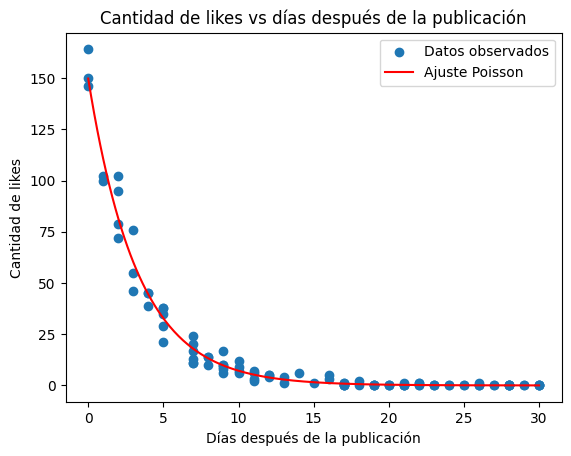

In [77]:
x_range_poisson = np.linspace(X.min(), X.max(), 300)
ajuste_poisson = np.exp(estimacion_poisson.x[0] + estimacion_poisson.x[1]*x_range_poisson)

# Armo el gráfico de X (días despues de la publicación) vs Y (cantidad de likes) junto con el ajuste
plt.scatter(X, Y, label='Datos observados')
plt.plot(x_range_poisson, ajuste_poisson, color='red', label='Ajuste Poisson')
plt.xlabel("Días después de la publicación")
plt.ylabel("Cantidad de likes")
plt.title("Cantidad de likes vs días después de la publicación")
plt.legend()
plt.show()

## c)
Determinar el error estándar de cada parámetro de regresión. Obtener un intervalo de confianza de 0.95 para cada uno. Graficar el GLM encima de los datos incluyendo un intervalo
de confianza para el modelo, usando el intervalo de confianza para 𝛽1 (el parámetro que acompaña a 𝑥 en la función lineal).

### Desarrollo

Para esto necesito obtener la **matriz de Fischer de la distribución**:

$$I = \frac{1}{\phi}X^TWX \hspace{1cm}\text{ con }W = \text{diag}(\frac{1}{V(\mu_i)(d\eta_i/d\mu_i)^2}) $$

En nuestro caso:
$$\phi = 1 $$

$$ V(\mu) = \mu $$

$$ \frac{d\eta}{d\mu} = \frac{d(\log(\mu))}{d\mu} = \frac{1}{\mu}$$

Por lo tanto $$I = X^TWX \hspace{1cm}W = \text{diag}(\mu_i) = \text{diag}(e^{\beta_0 + \beta_1x_i}) $$

Finalmente, la matriz de covarianza es $I^{-1}$ y su diagonal, las varianzas respectivas de $\beta_0$ y $\beta_1$. 

Ahora paso a obtener toda esta información:

In [68]:
from numpy.linalg import inv

mu = np.exp(X_intercepto@estimacion_poisson.x)
W = np.diag(mu)
I = X_intercepto.T@W@X_intercepto
cov_matrix = inv(I)
cov_matrix

array([[ 1.05361269e-03, -1.58456500e-04],
       [-1.58456500e-04,  5.15531331e-05]])

Calculo los errores estándar de los parámetros:

In [72]:
# Obtengo los errores estándar de los parámetros
se = np.sqrt(np.diag(cov_matrix))

# Imprimo los errores estándar junto con los parámetros estimados
print(f'Error estándar beta_0: {se[0]}')
print(f'Error estándar beta_1: {se[1]}')

Error estándar beta_0: 0.03245940067707844
Error estándar beta_1: 0.007180051051298239


Obtengo los intervalos de confianza a nivel 95% para cada beta:

In [80]:
IC_95_beta_0 = estimacion_poisson.x[0] + np.array([-1, 1])*1.96*se[0]
IC_95_beta_1 = estimacion_poisson.x[1] + np.array([-1, 1])*1.96*se[1]

print(f'Intervalo de confianza 95% para beta_0: {IC_95_beta_0}')
print(f'Intervalo de confianza 95% para beta_1: {IC_95_beta_1}')

Intervalo de confianza 95% para beta_0: [4.9455244  5.07276525]
Intervalo de confianza 95% para beta_1: [-0.31800503 -0.28985923]


Ahora voy a volver a generar de vuelta el gráfico que contiene a los datos observados y el modelo ajustado, pero esta vez también incluyo un intervalo de confianza para el modelo sobre b1 del 95%:

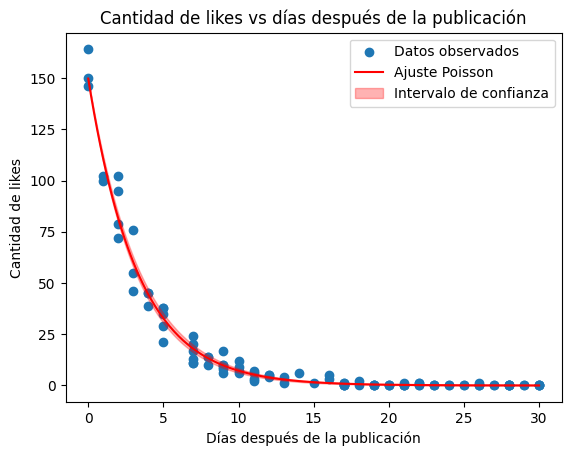

In [76]:
# Me guardo el error estándar de b1 
se_b1 = se[1]

# Obtengo los bordes del intervalo
borde_sup = np.exp(estimacion_poisson.x[0] + (estimacion_poisson.x[1] + 1.96*se_b1)*x_range_poisson)
borde_inf = np.exp(estimacion_poisson.x[0] + (estimacion_poisson.x[1] - 1.96*se_b1)*x_range_poisson)

# Armo el gráfico de X (días después de la publicación) vs Y (cantidad de likes) junto con el ajuste y el intervalo de confianza
plt.scatter(X, Y, label='Datos observados')
plt.plot(x_range_poisson, ajuste_poisson, color='red', label='Ajuste Poisson')
plt.fill_between(x_range_poisson, borde_inf, borde_sup, color='red', alpha=0.3, label='Intervalo de confianza')
plt.xlabel("Días después de la publicación")
plt.ylabel("Cantidad de likes")
plt.title("Cantidad de likes vs días después de la publicación")
plt.legend()
plt.show()